# TRAIN & TEST (Faster R-CNN MODEL) on PAVEL-AD DATASET

# **Install Required Packages**

In [ ]:
!pip install matplotlib
!pip install matplotlib opencv-python pillow tqdm pycocotools lxml torch torchvision
!pip install opencv-python
!pip install torch torchvision
!pip install pillow
!pip install tqdm
!pip install pycocotools
!pip install lxml

# Import Required Libraries



In [ ]:
# Import necessary libraries
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import xml.etree.ElementTree as ET
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import shutil
import cv2


## Extract the restructured_dataset.zip





In [ ]:
import zipfile
import os

# Path to the zip file
zip_path = '/content/restructured_dataset.zip'

# Destination folder to extract the files
extract_path = '/content/restructured_dataset/'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")


Dataset extracted to: /content/restructured_dataset/


# Extract Class Names

In [ ]:
# Extract class names from annotations
def extract_class_names(annotations_path):
    class_names = set()
    for annotation_file in os.listdir(annotations_path):
        tree = ET.parse(os.path.join(annotations_path, annotation_file))
        root = tree.getroot()
        for obj in root.findall("object"):
            class_names.add(obj.find("name").text.strip())
    return sorted(list(class_names))

# Get class names from train annotations
class_names = extract_class_names(train_annotations_path)
class_name_to_id = {name: idx + 1 for idx, name in enumerate(class_names)}  # Background is 0
class_id_to_name = {idx: name for name, idx in class_name_to_id.items()}

print("Class Names:", class_names)
print("Class to ID Mapping:", class_name_to_id)
print("ID to Class Mapping:", class_id_to_name)


Class Names: ['black_core', 'corner', 'crack', 'finger', 'fragment', 'horizontal_dislocation', 'printing_error', 'scratch', 'short_circuit', 'star_crack', 'thick_line', 'vertical_dislocation']
Class to ID Mapping: {'black_core': 1, 'corner': 2, 'crack': 3, 'finger': 4, 'fragment': 5, 'horizontal_dislocation': 6, 'printing_error': 7, 'scratch': 8, 'short_circuit': 9, 'star_crack': 10, 'thick_line': 11, 'vertical_dislocation': 12}
ID to Class Mapping: {1: 'black_core', 2: 'corner', 3: 'crack', 4: 'finger', 5: 'fragment', 6: 'horizontal_dislocation', 7: 'printing_error', 8: 'scratch', 9: 'short_circuit', 10: 'star_crack', 11: 'thick_line', 12: 'vertical_dislocation'}


# **Display Sample Images with Bounding Boxes**

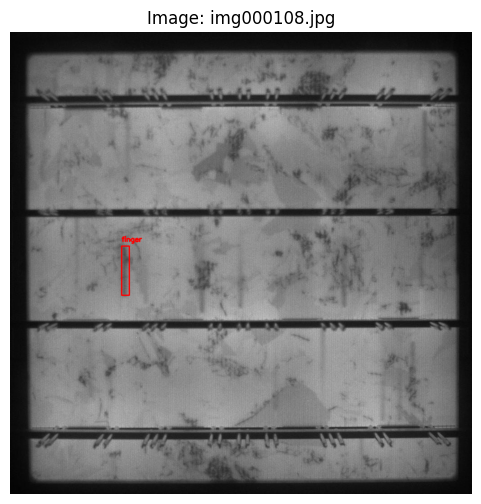

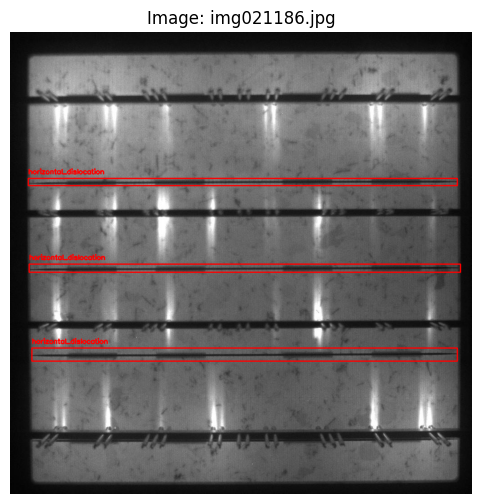

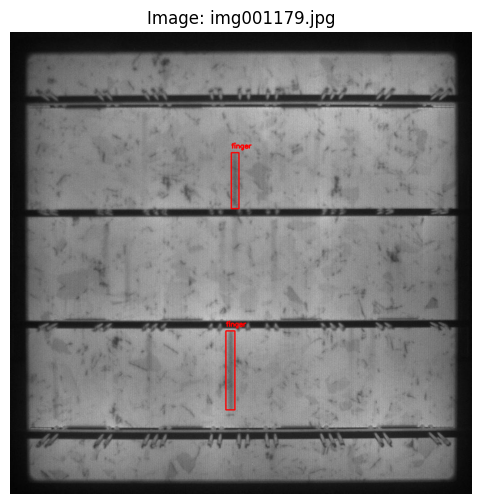

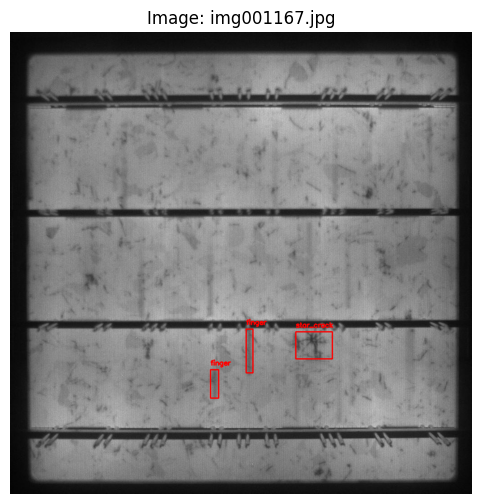

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

def display_sample_images_with_classes():
    sample_images = random.sample(train_images, min(4, len(train_images)))
    for img_file in sample_images:
        img_path = os.path.join(restructured_dataset, "train/images", img_file)
        annotation_path = os.path.join(restructured_dataset, "train/annotations", img_file.replace(".jpg", ".xml"))

        # Parse annotation to get bounding boxes and class names
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        bboxes = []
        classes = []
        for obj in root.findall("object"):
            # Extract class name
            class_name = obj.find("name").text
            classes.append(class_name)

            # Extract bounding box
            bbox = obj.find("bndbox")
            bboxes.append((
                int(bbox.find("xmin").text),
                int(bbox.find("ymin").text),
                int(bbox.find("xmax").text),
                int(bbox.find("ymax").text)
            ))

        # Display image with bounding boxes and class names
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for (xmin, ymin, xmax, ymax), class_name in zip(bboxes, classes):
            # Draw bounding box
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            # Overlay class name
            cv2.putText(
                img, class_name, (xmin, ymin - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2
            )

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Image: {img_file}")
        plt.axis("off")
    plt.show()

# Call the updated function
display_sample_images_with_classes()


# **Train the model**

In [ ]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import xml.etree.ElementTree as ET
from tqdm import tqdm

# Class names and mappings
class_names = ['black_core', 'corner', 'crack', 'finger', 'fragment', 'horizontal_dislocation',
               'printing_error', 'scratch', 'short_circuit', 'star_crack', 'thick_line', 'vertical_dislocation']
class_name_to_id = {name: idx + 1 for idx, name in enumerate(class_names)}  # Background is 0
id_to_class_name = {idx: name for name, idx in class_name_to_id.items()}

# Custom Dataset
class SolarPanelDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.images = sorted(os.listdir(image_dir))
        self.annotations = sorted(os.listdir(annotation_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_dir, self.images[idx])
        img = Image.open(img_path).convert("RGB")
        img = img.resize((1024, 1024))

        # Parse XML annotation
        annotation_path = os.path.join(self.annotation_dir, self.annotations[idx])
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text) * (1024 / img.width)
            ymin = int(bbox.find("ymin").text) * (1024 / img.height)
            xmax = int(bbox.find("xmax").text) * (1024 / img.width)
            ymax = int(bbox.find("ymax").text) * (1024 / img.height)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(class_name_to_id[obj.find("name").text.strip()])  # Convert to ID

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

# Transforms
def get_transforms():
    return ToTensor()

# Model Initialization
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Training Loop
def train_model(model, train_loader, optimizer, scheduler, device, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        print(f"Epoch {epoch+1}/{num_epochs}")
        for images, targets in tqdm(train_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()

            # Backward pass
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # Scheduler step
        scheduler.step()
        print(f"Epoch Loss: {epoch_loss:.4f}")

# Paths
train_images_path = "/content/restructured_dataset/train/images"
train_annotations_path = "/content/restructured_dataset/train/annotations"
test_images_path = "p/content/restructured_dataset/test/images"
test_annotations_path = "/content/restructured_dataset/test/annotations"

# Dataset and Dataloader
train_dataset = SolarPanelDataset(train_images_path, train_annotations_path, transforms=get_transforms())
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Initialize Model
num_classes = len(class_names) + 1  # Including background
model = get_model(num_classes)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Optimizer and Scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train Model
train_model(model, train_loader, optimizer, lr_scheduler, device, num_epochs=50)

# Save Model
torch.save(model.state_dict(), "faster_rcnn_solar_panel.pt")
print("Training complete. Model saved as faster_rcnn_solar_panel.pt")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 197MB/s]


Epoch 1/50


  0%|          | 1/232 [00:06<23:39,  6.15s/it]


KeyboardInterrupt: 

# Training Metrics Visualization

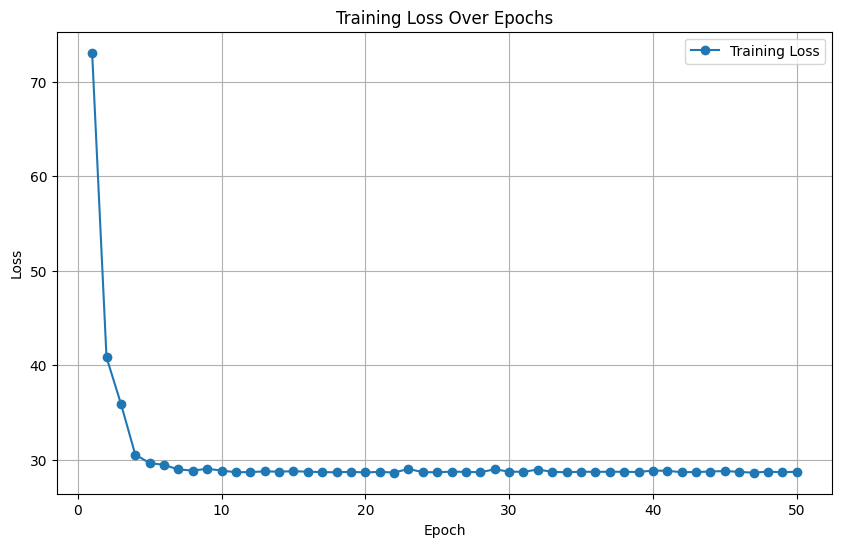

In [ ]:
import matplotlib.pyplot as plt

# Example: Replace this with your actual epoch_losses from training
epoch_losses = [
    73.0746, 40.8351, 35.9424, 30.5367, 29.6512, 29.4554, 28.9662, 28.8549,
    29.0373, 28.8588, 28.6693, 28.6975, 28.7599, 28.7418, 28.7771, 28.7358,
    28.6886, 28.6687, 28.7203, 28.6527, 28.7163, 28.6423, 29.0261, 28.6803,
    28.6716, 28.7389, 28.7130, 28.6752, 28.9830, 28.7396, 28.7172, 28.9627,
    28.7219, 28.6657, 28.7351, 28.7114, 28.7317, 28.7198, 28.7004, 28.8554,
    28.8244, 28.6816, 28.6934, 28.7524, 28.8001, 28.7160, 28.6238, 28.7441,d
    28.6692, 28.7337
]  # Replace with actual data if different

# Plot the training loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label="Training Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# Predected boxes VS Ground Trouth boxes




<ipython-input-11-d8886c6ebf8a>:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


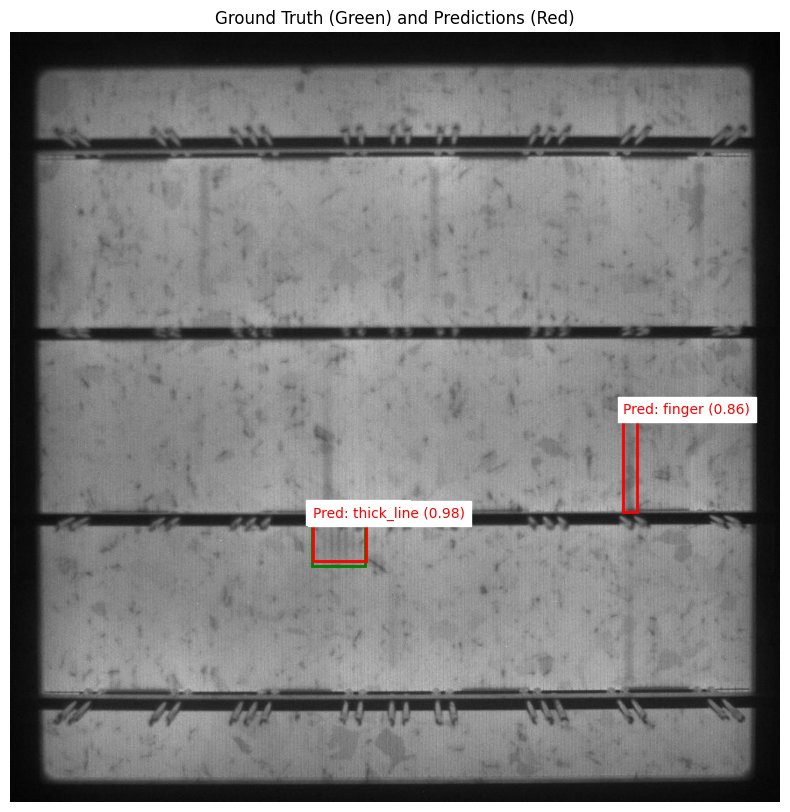

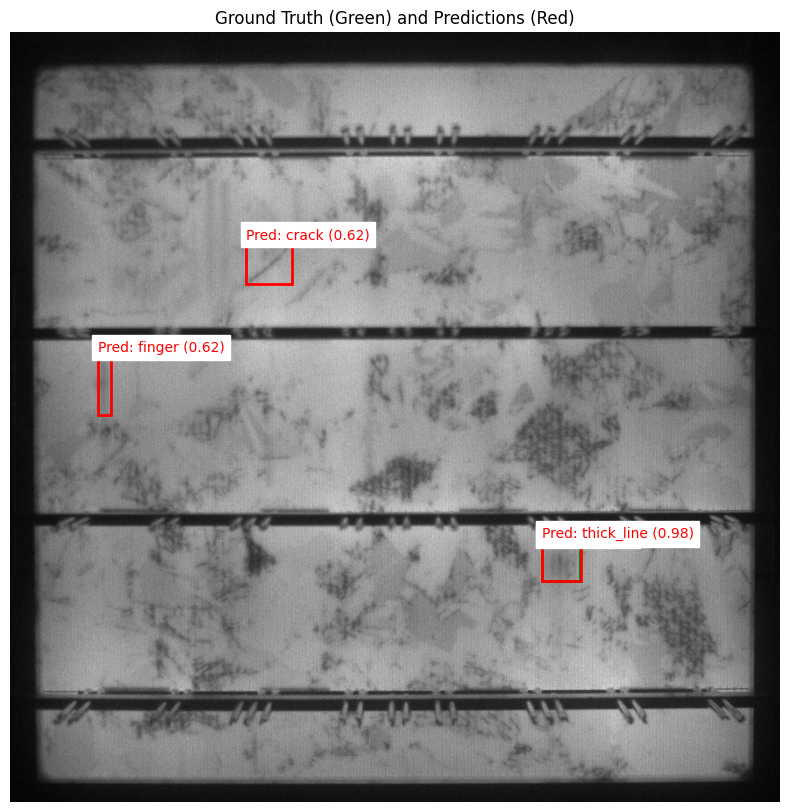

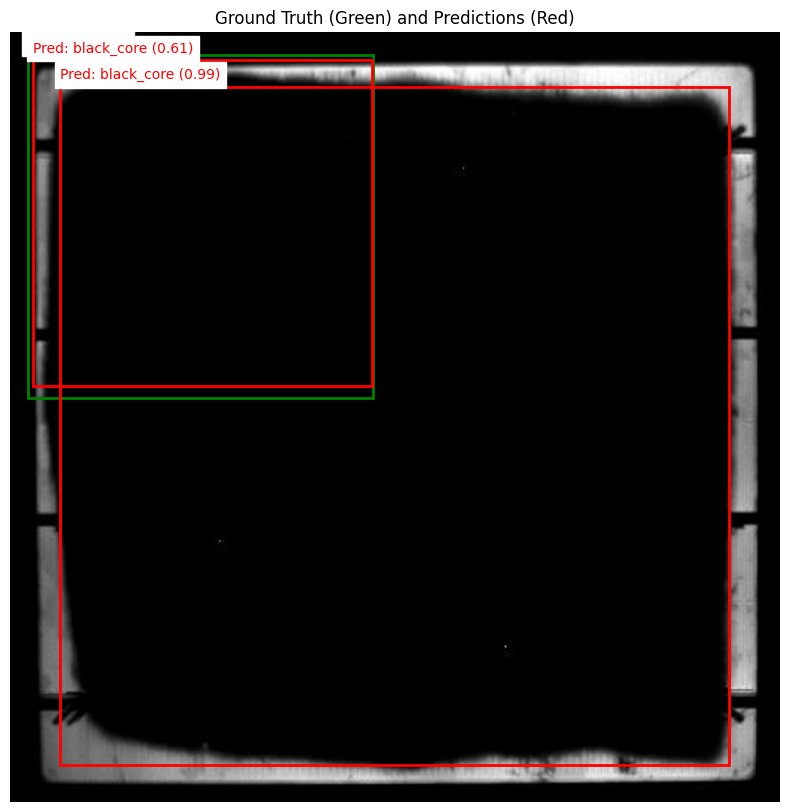

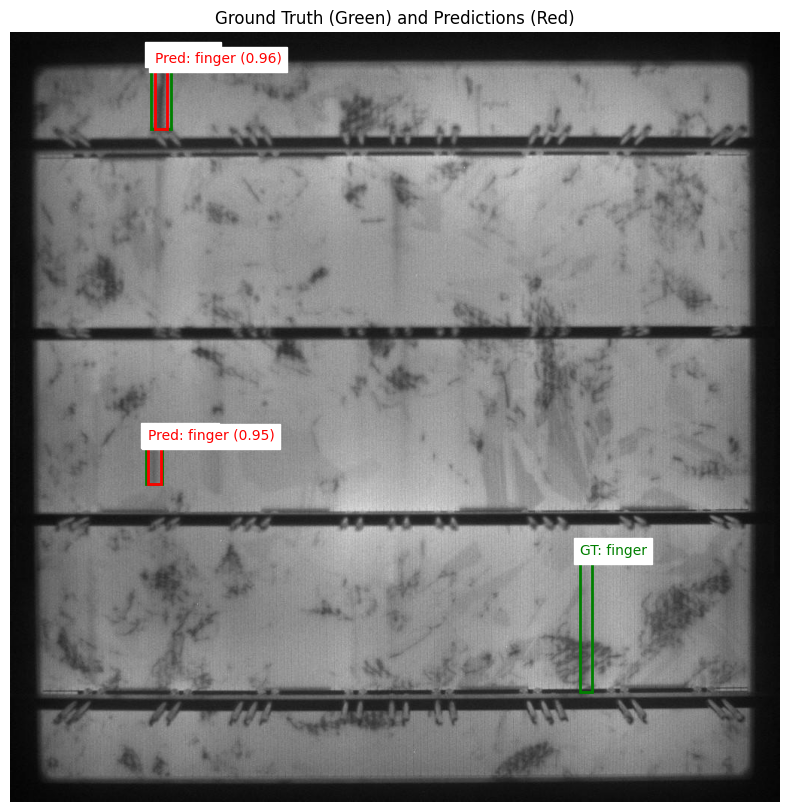

Accuracy (IoU > 0.5): 0.56


In [ ]:
import random
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Function to compute IoU (Intersection over Union)
def compute_iou(box1, box2):
    """
    Compute IoU between two bounding boxes.
    :param box1: [xmin, ymin, xmax, ymax] for the first box.
    :param box2: [xmin, ymin, xmax, ymax] for the second box.
    :return: IoU value.
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute intersection area
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Compute areas of both boxes
    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Compute union area
    union = area_box1 + area_box2 - intersection

    # Compute IoU
    return intersection / union if union > 0 else 0

# Function to visualize predictions, compute IoU, and calculate accuracy
def visualize_predictions_with_iou(model, dataset, device, iou_threshold=0.5, num_samples=4):
    model.eval()
    random_indices = random.sample(range(len(dataset)), num_samples)
    total_predictions = 0
    correct_predictions = 0

    for idx in random_indices:
        # Load image and target
        img, target = dataset[idx]
        img_tensor = img.to(device).unsqueeze(0)  # Add batch dimension

        # Perform inference
        with torch.no_grad():
            prediction = model(img_tensor)[0]

        # Convert image tensor to NumPy for visualization
        img_np = img.permute(1, 2, 0).cpu().numpy()  # Move to CPU for visualization

        # Plot image
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(img_np)

        # Plot ground truth boxes
        for box, label in zip(target["boxes"], target["labels"]):
            xmin, ymin, xmax, ymax = box.cpu().numpy()  # Move box to CPU
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor="green", facecolor="none"
            )
            ax.add_patch(rect)
            ax.text(
                xmin, ymin - 10,
                f"GT: {id_to_class_name[label.item()]}",
                color="green", fontsize=10, backgroundcolor="white"
            )

        # Plot predicted boxes and compute IoU
        for box, label, score in zip(prediction["boxes"], prediction["labels"], prediction["scores"]):
            if score > 0.5:  # Confidence threshold
                xmin, ymin, xmax, ymax = box.cpu().numpy()  # Move box to CPU
                rect = patches.Rectangle(
                    (xmin, ymin), xmax - xmin, ymax - ymin,
                    linewidth=2, edgecolor="red", facecolor="none"
                )
                ax.add_patch(rect)
                ax.text(
                    xmin, ymin - 10,
                    f"Pred: {id_to_class_name[label.item()]} ({score:.2f})",
                    color="red", fontsize=10, backgroundcolor="white"
                )

                # Compute IoU for ground truth and prediction
                for gt_box in target["boxes"]:
                    iou = compute_iou([xmin, ymin, xmax, ymax], gt_box.cpu().numpy())
                    if iou > iou_threshold:
                        correct_predictions += 1
                        break  # Stop once a match is found

                total_predictions += 1

        ax.set_title("Ground Truth (Green) and Predictions (Red)")
        ax.axis("off")
        plt.show()

    # Compute accuracy
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"Accuracy (IoU > {iou_threshold}): {accuracy:.2f}")

# Paths
test_images_path = "/content/restructured_dataset/test/images"
test_annotations_path = "/content/restructured_dataset/test/annotations"

# Load the trained model
model_path = "/content/faster_rcnn_solar_panel.pt"  # Path to the .pt model
model = get_model(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Test dataset
test_dataset = SolarPanelDataset(test_images_path, test_annotations_path, transforms=get_transforms())

# Visualize predictions, compute IoU, and calculate accuracy
visualize_predictions_with_iou(model, test_dataset, device, iou_threshold=0.5, num_samples=4)


# Test the model on all the test set

---



In [ ]:
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
import numpy as np

# Function to compute IoU (Intersection over Union)
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union = area_box1 + area_box2 - intersection
    return intersection / union if union > 0 else 0

# Function to evaluate the model on the test dataset
def evaluate_model(model, dataloader, device, iou_threshold=0.5):
    model.eval()
    num_classes = len(class_names)
    all_y_true = [[] for _ in range(num_classes)]  # One list per class
    all_scores = [[] for _ in range(num_classes)]  # One list per class

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                ground_truth_boxes = targets[i]["boxes"].cpu().numpy()
                ground_truth_labels = targets[i]["labels"].cpu().numpy()

                predicted_boxes = output["boxes"].cpu().numpy()
                predicted_labels = output["labels"].cpu().numpy()
                predicted_scores = output["scores"].cpu().numpy()

                for j, pred_box in enumerate(predicted_boxes):
                    max_iou = 0
                    matched_gt_idx = -1

                    for k, gt_box in enumerate(ground_truth_boxes):
                        iou = compute_iou(pred_box, gt_box)
                        if iou > max_iou:
                            max_iou = iou
                            matched_gt_idx = k

                    if max_iou >= iou_threshold:
                        class_idx = int(ground_truth_labels[matched_gt_idx]) - 1
                        all_y_true[class_idx].append(1)
                        all_scores[class_idx].append(predicted_scores[j])
                    else:
                        class_idx = int(predicted_labels[j]) - 1
                        all_y_true[class_idx].append(0)
                        all_scores[class_idx].append(predicted_scores[j])

    # Convert to numpy arrays for sklearn metrics
    all_y_true = [np.array(y_true) for y_true in all_y_true]
    all_scores = [np.array(scores) for scores in all_scores]

    # Compute mAP
    aps = []
    for y_true, scores in zip(all_y_true, all_scores):
        if len(y_true) > 0:  # Ensure there are samples for the class
            aps.append(average_precision_score(y_true, scores))
    mAP = np.mean(aps) if aps else 0

    # Compute overall precision, recall, and F1 score
    all_flat_y_true = np.concatenate(all_y_true)
    all_flat_y_pred = np.concatenate([[1 if score > 0.5 else 0 for score in scores] for scores in all_scores])
    precision, recall, f1, _ = precision_recall_fscore_support(all_flat_y_true, all_flat_y_pred, average="binary")

    return precision, recall, f1, mAP

# Paths
test_images_path = "/content/restructured_dataset/test/images"
test_annotations_path = "/content/restructured_dataset/test/annotations"

# Test dataset and dataloader
test_dataset = SolarPanelDataset(test_images_path, test_annotations_path, transforms=get_transforms())
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Load the trained model
model_path = "/content/faster_rcnn_solar_panel.pt"
model = get_model(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Evaluate the model
precision, recall, f1, mAP = evaluate_model(model, test_loader, device)

# Print results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Mean Average Precision (mAP): {mAP:.4f}")


<ipython-input-16-59c803576aaa>:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Precision: 0.6847
Recall: 0.7368
F1 Score: 0.7098
Mean Average Precision (mAP): 0.7496


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


**fine tuning**

In [ ]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToTensor
from tqdm import tqdm
from PIL import Image
import xml.etree.ElementTree as ET

# Class names and mappings
class_names = ['black_core', 'corner', 'crack', 'finger', 'fragment', 'horizontal_dislocation',
               'printing_error', 'scratch', 'short_circuit', 'star_crack', 'thick_line', 'vertical_dislocation']
class_name_to_id = {name: idx + 1 for idx, name in enumerate(class_names)}

# Custom Dataset
class SolarPanelDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.images = sorted(os.listdir(image_dir))
        self.annotations = sorted(os.listdir(annotation_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_dir, self.images[idx])
        img = Image.open(img_path).convert("RGB")
        img = img.resize((1024, 1024))

        # Load annotation
        annotation_path = os.path.join(self.annotation_dir, self.annotations[idx])
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(class_name_to_id[obj.find("name").text.strip()])

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

# Function to load the model with pre-trained weights
def load_model(checkpoint_path, num_classes, device):
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

    # Load the pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Load saved weights
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    return model

# Function for fine-tuning
def fine_tune_model(model, train_loader, optimizer, scheduler, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for images, targets in tqdm(train_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()

            # Backward pass
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # Scheduler step
        scheduler.step()
        print(f"Epoch Loss: {epoch_loss:.4f}")

# Paths
train_images_path = "/content/restructured_dataset/train/images"
train_annotations_path = "/content/restructured_dataset/train/annotations"
checkpoint_path = "/content/faster_rcnn_solar_panel.pt"

# Ensure paths exist
assert os.path.exists(train_images_path), f"Training images path not found: {train_images_path}"
assert os.path.exists(train_annotations_path), f"Training annotations path not found: {train_annotations_path}"
assert os.path.exists(checkpoint_path), f"Checkpoint path not found: {checkpoint_path}"

# Dataset and Dataloader
train_dataset = SolarPanelDataset(train_images_path, train_annotations_path, transforms=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Load model
num_classes = len(class_names) + 1  # Including background
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = load_model(checkpoint_path, num_classes, device)
model.to(device)

# Optimizer and Scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Fine-tune the model for 30 epochs
fine_tune_model(model, train_loader, optimizer, lr_scheduler, device, num_epochs=10)

# Save the fine-tuned model
torch.save(model.state_dict(), "/content/faster_rcnn_solar_panel_finetuned.pt")
print("Fine-tuning complete. Model saved as /content/faster_rcnn_solar_panel_finetuned.pt")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-17-4c86992d5e20>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Epoch 1/10


100%|██████████| 463/463 [02:02<00:00,  3.77it/s]


Epoch Loss: 70.4643
Epoch 2/10


100%|██████████| 463/463 [02:03<00:00,  3.76it/s]


Epoch Loss: 63.2132
Epoch 3/10


100%|██████████| 463/463 [02:04<00:00,  3.73it/s]


Epoch Loss: 57.2650
Epoch 4/10


100%|██████████| 463/463 [02:03<00:00,  3.74it/s]


Epoch Loss: 47.1988
Epoch 5/10


100%|██████████| 463/463 [02:03<00:00,  3.73it/s]


Epoch Loss: 45.2449
Epoch 6/10


100%|██████████| 463/463 [02:03<00:00,  3.74it/s]


Epoch Loss: 44.4784
Epoch 7/10


100%|██████████| 463/463 [02:03<00:00,  3.74it/s]


Epoch Loss: 43.4377
Epoch 8/10


100%|██████████| 463/463 [02:03<00:00,  3.75it/s]


Epoch Loss: 43.1531
Epoch 9/10


100%|██████████| 463/463 [02:03<00:00,  3.74it/s]


Epoch Loss: 43.0944
Epoch 10/10


100%|██████████| 463/463 [02:03<00:00,  3.75it/s]


Epoch Loss: 43.2010
Fine-tuning complete. Model saved as /content/faster_rcnn_solar_panel_finetuned.pt


In [ ]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToTensor
from tqdm import tqdm
from PIL import Image
import xml.etree.ElementTree as ET

# Class names and mappings
class_names = ['black_core', 'corner', 'crack', 'finger', 'fragment', 'horizontal_dislocation',
               'printing_error', 'scratch', 'short_circuit', 'star_crack', 'thick_line', 'vertical_dislocation']
class_name_to_id = {name: idx + 1 for idx, name in enumerate(class_names)}

# Custom Dataset
class SolarPanelDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.images = sorted(os.listdir(image_dir))
        self.annotations = sorted(os.listdir(annotation_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_dir, self.images[idx])
        img = Image.open(img_path).convert("RGB")
        img = img.resize((1024, 1024))

        # Load annotation
        annotation_path = os.path.join(self.annotation_dir, self.annotations[idx])
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(class_name_to_id[obj.find("name").text.strip()])

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

# Function to load the model with pre-trained weights
def load_model(checkpoint_path, num_classes, device):
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

    # Load the pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Load saved weights
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    return model

# Function for fine-tuning
def fine_tune_model(model, train_loader, optimizer, scheduler, device, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for images, targets in tqdm(train_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()

            # Backward pass
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # Scheduler step
        scheduler.step()
        print(f"Epoch Loss: {epoch_loss:.4f}")

# Paths
train_images_path = "/content/restructured_dataset/train/images"
train_annotations_path = "/content/restructured_dataset/train/annotations"
checkpoint_path = "/content/faster_rcnn_solar_panel_finetuned.pt"

# Ensure paths exist
assert os.path.exists(train_images_path), f"Training images path not found: {train_images_path}"
assert os.path.exists(train_annotations_path), f"Training annotations path not found: {train_annotations_path}"
assert os.path.exists(checkpoint_path), f"Checkpoint path not found: {checkpoint_path}"

# Dataset and Dataloader
train_dataset = SolarPanelDataset(train_images_path, train_annotations_path, transforms=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Load model
num_classes = len(class_names) + 1  # Including background
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = load_model(checkpoint_path, num_classes, device)
model.to(device)

# Optimizer and Scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Fine-tune the model for 30 epochs
fine_tune_model(model, train_loader, optimizer, lr_scheduler, device, num_epochs=30)

# Save the fine-tuned model
torch.save(model.state_dict(), "/content/faster_rcnn_solar_panel_finetuned1.pt")
print("Fine-tuning complete. Model saved as /content/faster_rcnn_solar_panel_finetuned1.pt")


<ipython-input-20-3b9c761576f6>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Epoch 1/30


100%|██████████| 463/463 [11:38<00:00,  1.51s/it]


Epoch Loss: 52.3071
Epoch 2/30


100%|██████████| 463/463 [11:37<00:00,  1.51s/it]


Epoch Loss: 50.6584
Epoch 3/30


100%|██████████| 463/463 [11:37<00:00,  1.51s/it]


Epoch Loss: 47.1106
Epoch 4/30


100%|██████████| 463/463 [11:37<00:00,  1.51s/it]


Epoch Loss: 38.9031
Epoch 5/30


100%|██████████| 463/463 [11:37<00:00,  1.51s/it]


Epoch Loss: 37.2422
Epoch 6/30


100%|██████████| 463/463 [11:36<00:00,  1.50s/it]


Epoch Loss: 36.4470
Epoch 7/30


100%|██████████| 463/463 [11:36<00:00,  1.50s/it]


Epoch Loss: 35.3713
Epoch 8/30


100%|██████████| 463/463 [11:37<00:00,  1.51s/it]


Epoch Loss: 35.4864
Epoch 9/30


100%|██████████| 463/463 [11:37<00:00,  1.51s/it]


Epoch Loss: 35.1634
Epoch 10/30


100%|██████████| 463/463 [11:39<00:00,  1.51s/it]


Epoch Loss: 35.2040
Epoch 11/30


100%|██████████| 463/463 [11:38<00:00,  1.51s/it]


Epoch Loss: 35.1580
Epoch 12/30


100%|██████████| 463/463 [11:38<00:00,  1.51s/it]


Epoch Loss: 35.1327
Epoch 13/30


100%|██████████| 463/463 [11:37<00:00,  1.51s/it]


Epoch Loss: 35.1545
Epoch 14/30


100%|██████████| 463/463 [11:38<00:00,  1.51s/it]


Epoch Loss: 35.1019
Epoch 15/30


100%|██████████| 463/463 [11:37<00:00,  1.51s/it]


Epoch Loss: 35.1446
Epoch 16/30


 68%|██████▊   | 315/463 [07:55<03:44,  1.52s/it]

# Test the model on all the test set after Fine-tuning

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
import numpy as np

# Function to compute IoU (Intersection over Union)
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union = area_box1 + area_box2 - intersection
    return intersection / union if union > 0 else 0

# Function to evaluate the model on the test dataset
def evaluate_model(model, dataloader, device, iou_threshold=0.5):
    model.eval()
    num_classes = len(class_names)
    all_y_true = [[] for _ in range(num_classes)]  # One list per class
    all_scores = [[] for _ in range(num_classes)]  # One list per class

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                ground_truth_boxes = targets[i]["boxes"].cpu().numpy()
                ground_truth_labels = targets[i]["labels"].cpu().numpy()

                predicted_boxes = output["boxes"].cpu().numpy()
                predicted_labels = output["labels"].cpu().numpy()
                predicted_scores = output["scores"].cpu().numpy()

                for j, pred_box in enumerate(predicted_boxes):
                    max_iou = 0
                    matched_gt_idx = -1

                    for k, gt_box in enumerate(ground_truth_boxes):
                        iou = compute_iou(pred_box, gt_box)
                        if iou > max_iou:
                            max_iou = iou
                            matched_gt_idx = k

                    if max_iou >= iou_threshold:
                        class_idx = int(ground_truth_labels[matched_gt_idx]) - 1
                        all_y_true[class_idx].append(1)
                        all_scores[class_idx].append(predicted_scores[j])
                    else:
                        class_idx = int(predicted_labels[j]) - 1
                        all_y_true[class_idx].append(0)
                        all_scores[class_idx].append(predicted_scores[j])

    # Convert to numpy arrays for sklearn metrics
    all_y_true = [np.array(y_true) for y_true in all_y_true]
    all_scores = [np.array(scores) for scores in all_scores]

    # Compute mAP
    aps = []
    for y_true, scores in zip(all_y_true, all_scores):
        if len(y_true) > 0:  # Ensure there are samples for the class
            aps.append(average_precision_score(y_true, scores))
    mAP = np.mean(aps) if aps else 0

    # Compute overall precision, recall, and F1 score
    all_flat_y_true = np.concatenate(all_y_true)
    all_flat_y_pred = np.concatenate([[1 if score > 0.5 else 0 for score in scores] for scores in all_scores])
    precision, recall, f1, _ = precision_recall_fscore_support(all_flat_y_true, all_flat_y_pred, average="binary")

    return precision, recall, f1, mAP

# Paths
test_images_path = "/content/restructured_dataset/test/images"
test_annotations_path = "/content/restructured_dataset/test/annotations"

# Test dataset and dataloader
test_dataset = SolarPanelDataset(test_images_path, test_annotations_path, transforms=get_transforms())
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Load the trained model
model_path = "/content/faster_rcnn_solar_panel_finetuned.pt"
model = get_model(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Evaluate the model
precision, recall, f1, mAP = evaluate_model(model, test_loader, device)

# Print results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Mean Average Precision (mAP): {mAP:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-19-95f9a8a4583c>:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrust

Precision: 0.7345
Recall: 0.8014
F1 Score: 0.7665
Mean Average Precision (mAP): 0.8162


In [ ]:
from google.colab import files
files.download('/content/faster_rcnn_solar_panel_finetuned.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Predected boxes VS Ground Trouth boxes after finetuning


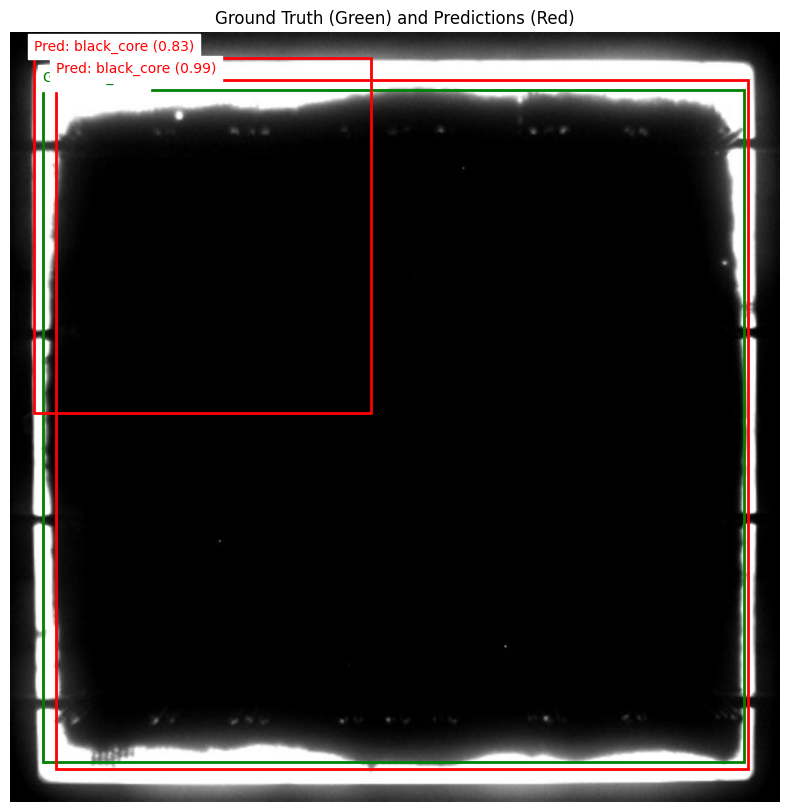

Image 116:

Ground Truths:
 - Box: [ 44.  76. 975. 970.], Label: black_core

Predictions:
 - Box: [ 60.203632  63.315117 981.1744   980.2792  ], Label: black_core, Score: 0.9916470050811768, IoU: 0.9521391101580581
 - Box: [ 31.109648  34.18199  479.20316  506.05902 ], Label: black_core, Score: 0.8253053426742554, IoU: No match


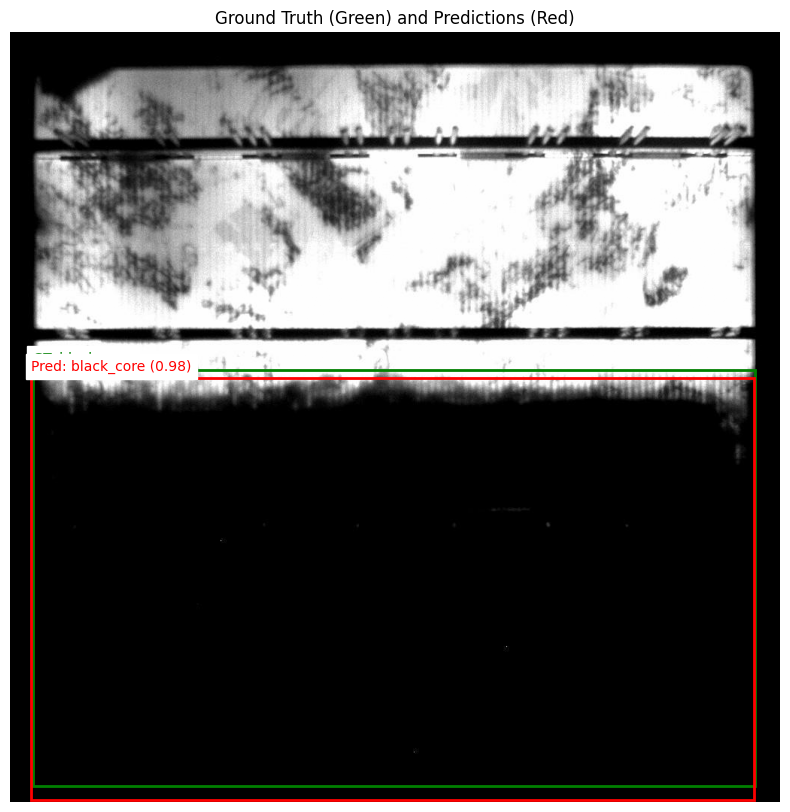

Image 734:

Ground Truths:
 - Box: [  30.  449.  990. 1002.], Label: black_core

Predictions:
 - Box: [  27.848671  459.2846    989.0754   1020.18835 ], Label: black_core, Score: 0.9818556904792786, IoU: 0.9472707292322997


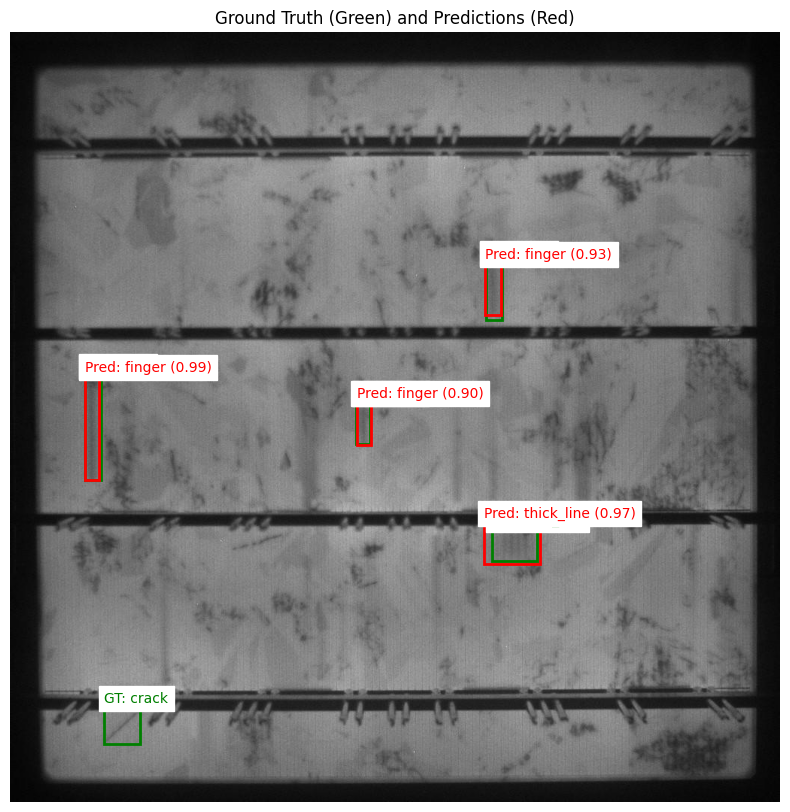

Image 490:

Ground Truths:
 - Box: [ 99. 460. 120. 595.], Label: finger
 - Box: [640. 663. 701. 703.], Label: thick_line
 - Box: [125. 901. 173. 947.], Label: crack
 - Box: [632. 309. 654. 382.], Label: finger
 - Box: [460. 496. 478. 547.], Label: finger

Predictions:
 - Box: [ 99.2229   460.67493  118.084694 595.51074 ], Label: finger, Score: 0.9914729595184326, IoU: 0.895292975112367
 - Box: [629.3646  655.0484  704.0966  706.85266], Label: thick_line, Score: 0.9738883972167969, IoU: 0.6356633728077156
 - Box: [631.6689  310.75293 652.96594 376.3354 ], Label: finger, Score: 0.9321172833442688, IoU: 0.8483219263501881
 - Box: [461.107   495.34995 479.26395 549.364  ], Label: finger, Score: 0.9008403420448303, IoU: 0.8371255846147682


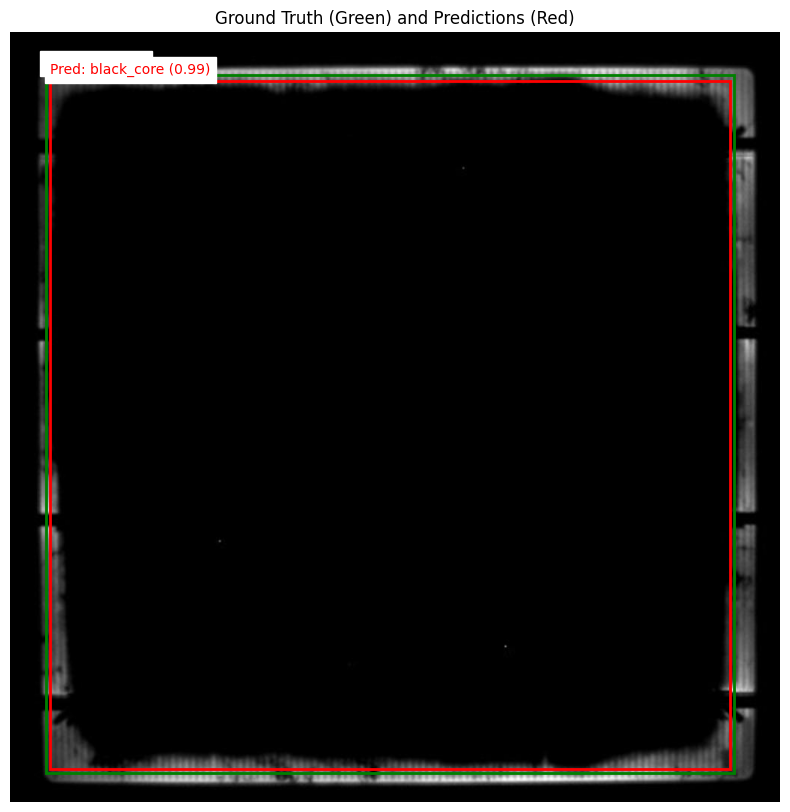

Image 134:

Ground Truths:
 - Box: [ 47.  57. 962. 985.], Label: black_core

Predictions:
 - Box: [ 52.837185  65.31504  957.4214   980.184   ], Label: black_core, Score: 0.9881429076194763, IoU: 0.9746551949515307


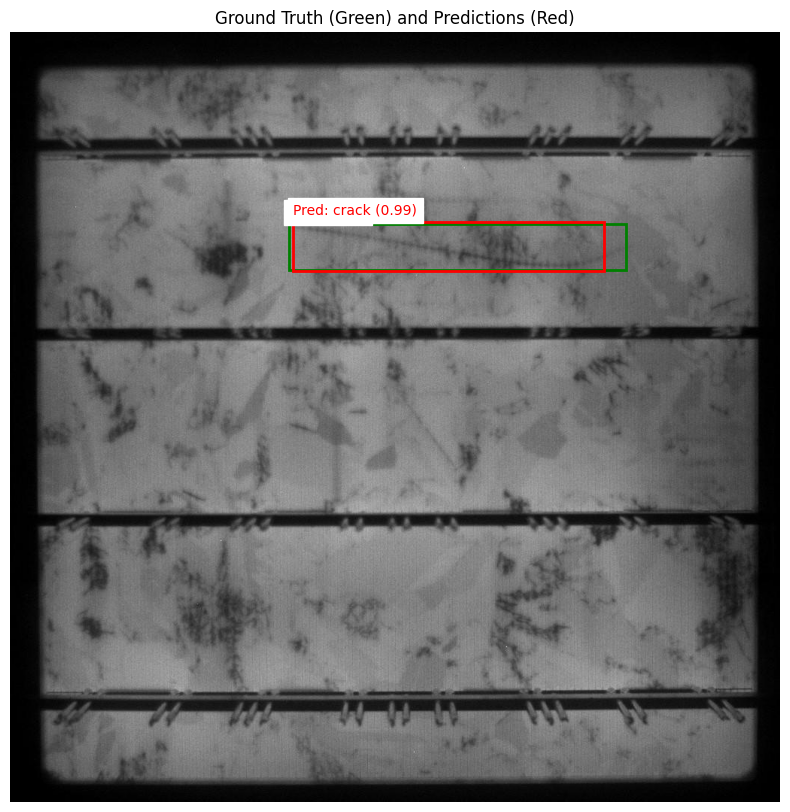

Image 666:

Ground Truths:
 - Box: [371. 255. 819. 316.], Label: scratch

Predictions:
 - Box: [376.48453 251.7298  789.32837 316.84756], Label: crack, Score: 0.9850443601608276, IoU: 0.8685336244708727


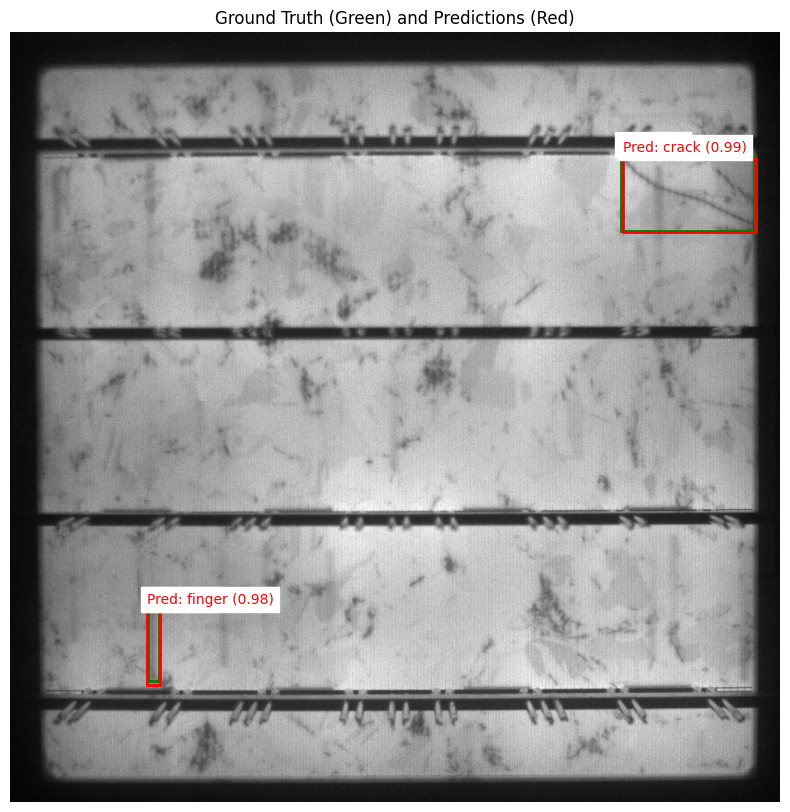

Image 246:

Ground Truths:
 - Box: [812. 165. 990. 264.], Label: crack
 - Box: [183. 769. 197. 863.], Label: finger

Predictions:
 - Box: [814.45654 167.88214 991.2592  264.85065], Label: crack, Score: 0.988166332244873, IoU: 0.943433300977934
 - Box: [181.27507 769.3907  199.19675 867.7096 ], Label: finger, Score: 0.98093581199646, IoU: 0.7528031257303468


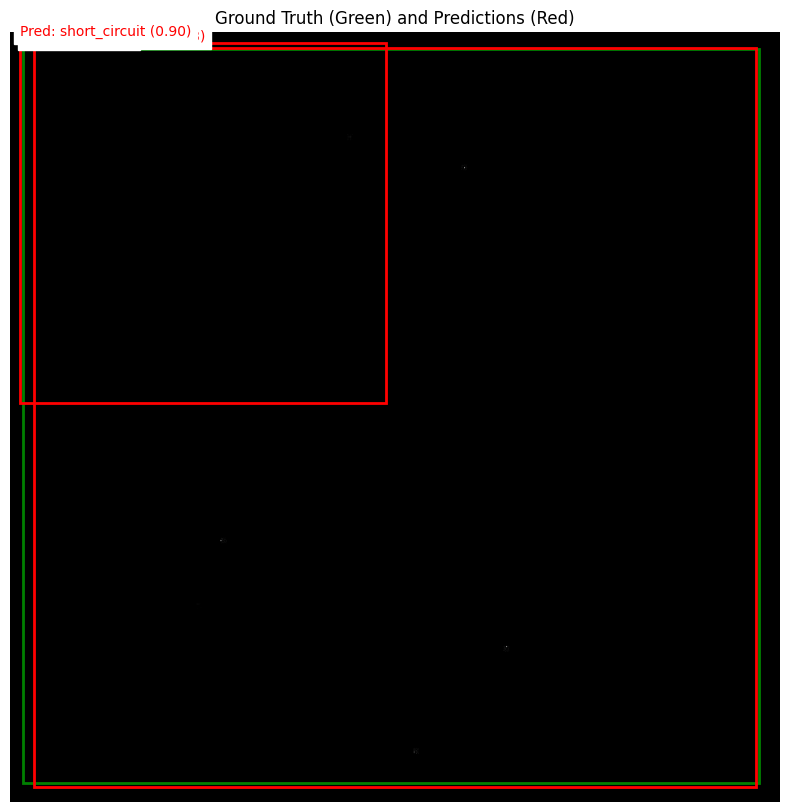

Image 880:

Ground Truths:
 - Box: [ 17.  22. 996. 998.], Label: short_circuit

Predictions:
 - Box: [  31.446054   21.194492  992.167    1004.19745 ], Label: short_circuit, Score: 0.9296808838844299, IoU: 0.9744932278650091
 - Box: [ 12.345644  14.21291  500.06952  492.44647 ], Label: short_circuit, Score: 0.9023082256317139, IoU: No match


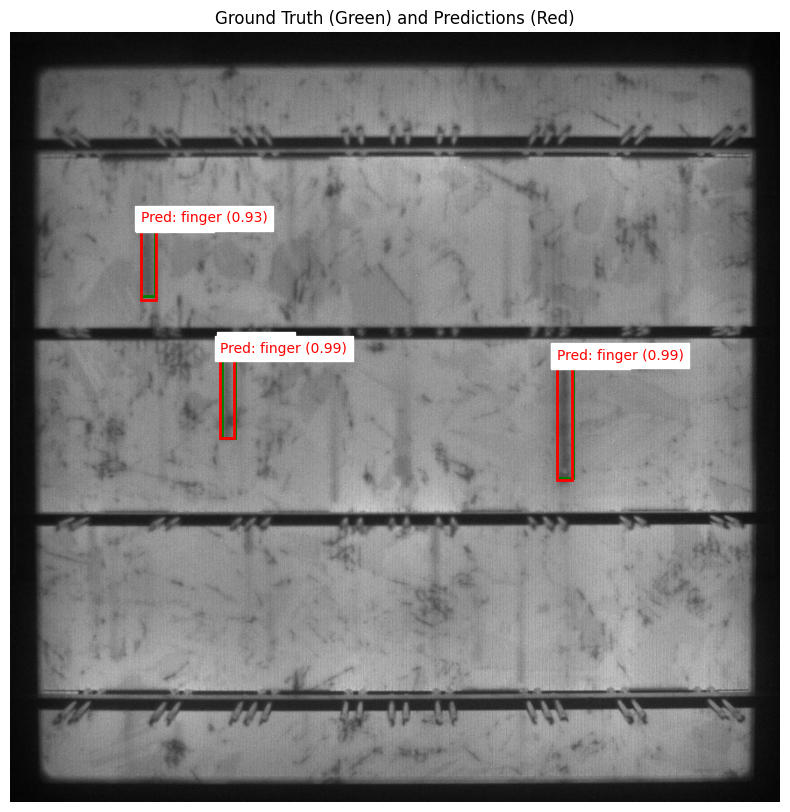

Image 133:

Ground Truths:
 - Box: [174. 264. 192. 350.], Label: finger
 - Box: [727. 446. 748. 592.], Label: finger
 - Box: [282. 431. 299. 539.], Label: finger

Predictions:
 - Box: [726.8885 445.2435 746.7849 595.7238], Label: finger, Score: 0.9917395114898682, IoU: 0.9136867875977353
 - Box: [278.91028 436.18686 297.6369  539.1828 ], Label: finger, Score: 0.9852755069732666, IoU: 0.7554056355616572
 - Box: [173.1202  262.2598  193.30734 356.01773], Label: finger, Score: 0.9305868148803711, IoU: 0.8233504854684044

Overall Accuracy (IoU > 0.5): 0.88


In [ ]:
import random
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Function to compute IoU (Intersection over Union)
def compute_iou(box1, box2):
    """
    Compute IoU between two bounding boxes.
    :param box1: [xmin, ymin, xmax, ymax] for the first box.
    :param box2: [xmin, ymin, xmax, ymax] for the second box.
    :return: IoU value.
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute intersection area
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Compute areas of both boxes
    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Compute union area
    union = area_box1 + area_box2 - intersection

    # Compute IoU
    return intersection / union if union > 0 else 0

# Function to visualize predictions with detailed descriptions
def visualize_predictions_with_detailed_analysis(model, dataset, device, iou_threshold=0.5, num_samples=8):
    model.eval()
    random_indices = random.sample(range(len(dataset)), num_samples)
    total_predictions = 0
    correct_predictions = 0

    for idx in random_indices:
        # Load image and target
        img, target = dataset[idx]
        img_tensor = img.to(device).unsqueeze(0)

        # Perform inference
        with torch.no_grad():
            prediction = model(img_tensor)[0]

        # Convert image tensor to NumPy for visualization
        img_np = img.permute(1, 2, 0).cpu().numpy()  # Move to CPU for visualization

        # Plot image
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(img_np)

        # Ground truth boxes and labels
        gt_details = []
        for box, label in zip(target["boxes"], target["labels"]):
            xmin, ymin, xmax, ymax = box.cpu().numpy()  # Move box to CPU
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor="green", facecolor="none"
            )
            ax.add_patch(rect)
            ax.text(
                xmin, ymin - 10,
                f"GT: {id_to_class_name[label.item()]}",
                color="green", fontsize=10, backgroundcolor="white"
            )
            gt_details.append({"box": box.cpu().numpy(), "label": id_to_class_name[label.item()]})

        # Prediction boxes and labels
        pred_details = []
        for box, label, score in zip(prediction["boxes"], prediction["labels"], prediction["scores"]):
            if score > 0.5:  # Confidence threshold
                xmin, ymin, xmax, ymax = box.cpu().numpy()  # Move box to CPU
                rect = patches.Rectangle(
                    (xmin, ymin), xmax - xmin, ymax - ymin,
                    linewidth=2, edgecolor="red", facecolor="none"
                )
                ax.add_patch(rect)
                ax.text(
                    xmin, ymin - 10,
                    f"Pred: {id_to_class_name[label.item()]} ({score:.2f})",
                    color="red", fontsize=10, backgroundcolor="white"
                )

                # Compute IoU for ground truth and prediction
                match_found = False
                for gt_box in target["boxes"]:
                    iou = compute_iou([xmin, ymin, xmax, ymax], gt_box.cpu().numpy())
                    if iou > iou_threshold:
                        correct_predictions += 1
                        match_found = True
                        pred_details.append({
                            "box": box.cpu().numpy(),
                            "label": id_to_class_name[label.item()],
                            "score": score.item(),
                            "iou": iou
                        })
                        break

                if not match_found:
                    pred_details.append({
                        "box": box.cpu().numpy(),
                        "label": id_to_class_name[label.item()],
                        "score": score.item(),
                        "iou": "No match"
                    })

                total_predictions += 1

        ax.set_title("Ground Truth (Green) and Predictions (Red)")
        ax.axis("off")
        plt.show()

        # Print details of ground truths and predictions
        print(f"Image {idx}:")
        print("\nGround Truths:")
        for gt in gt_details:
            print(f" - Box: {gt['box']}, Label: {gt['label']}")

        print("\nPredictions:")
        for pred in pred_details:
            print(f" - Box: {pred['box']}, Label: {pred['label']}, Score: {pred['score']}, IoU: {pred['iou']}")

    # Compute accuracy
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"\nOverall Accuracy (IoU > {iou_threshold}): {accuracy:.2f}")

# Run the function
visualize_predictions_with_detailed_analysis(model, test_dataset, device, iou_threshold=0.5, num_samples=8)
